In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np 
import pandas as pd 
import seaborn as sns

import pandas_profiling

from sklearn.metrics import mean_squared_error

## Прочитайте DUQ_hourly.csv и проверьте качество и порядок разметки этой выборки с информацией о потреблении энергии в одном из районов Восточной Электросети США. Сделайте описание особенностей этой выборки.

#### Загрузка данных

In [2]:
hourly = pd.read_csv('DUQ_hourly.csv', index_col=[0], parse_dates=[0])

#### Сразу визуализируем ряд

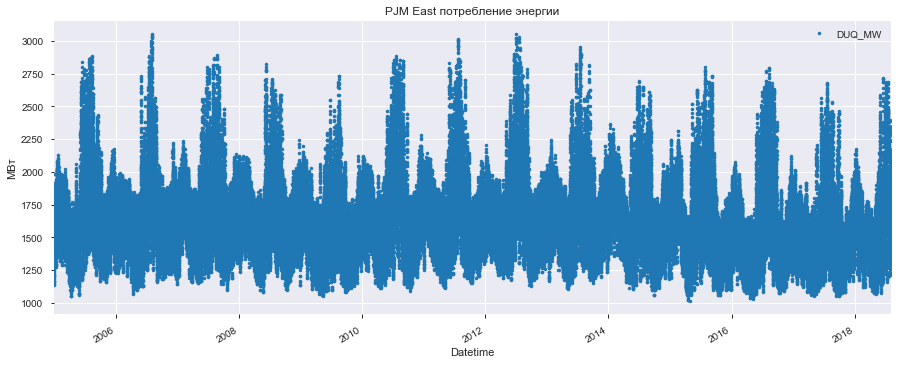

In [3]:
hourly.plot(style='.', figsize=(15, 6), title='PJM East потребление энергии')
plt.ylabel('МВт');

#### Визуальный анализ показывает циклический характер данных.

#### Посмотрим на статистику

In [4]:
pandas_profiling.ProfileReport(hourly)

#### Поскольку данные лежат в диапазоне от 1014МВт до 3054МВт, то очевидно, что точность представления float64 избыточна. Перейдем к целым.

In [5]:
hourly['DUQ_MW'] = hourly['DUQ_MW'].astype('int64')

In [6]:
hourly.head()

,DUQ_MW
Datetime,
2005-12-31 01:00:00,1458
2005-12-31 02:00:00,1377
2005-12-31 03:00:00,1351
2005-12-31 04:00:00,1336
2005-12-31 05:00:00,1356


#### Добавим поле "Дата" для дальнейшей работы

In [7]:
hourly['date'] = hourly.index

In [8]:
# проверим пропуски
hourly['DUQ_MW'].isnull().sum()

0

In [9]:
# проверим задвоения индексов
hourly.index.nunique()

119064

#### Пропусков нет, но есть дни, когда были зафиксированы показания потребления электроэнергии под одним индексом дважды.

In [10]:
hourly.index.value_counts().nlargest()

2017-11-05 02:00:00    2
2014-11-02 02:00:00    2
2015-11-01 02:00:00    2
2016-11-06 02:00:00    2
2007-07-15 10:00:00    1
Name: Datetime, dtype: int64

In [11]:
day_H=hourly['2017-11-01 00:00:00':'2017-11-10 23:00:00'].index.day

In [12]:
day_H.value_counts()

5     25
10    24
9     24
8     24
7     24
6     24
4     24
3     24
2     24
1     24
Name: Datetime, dtype: int64

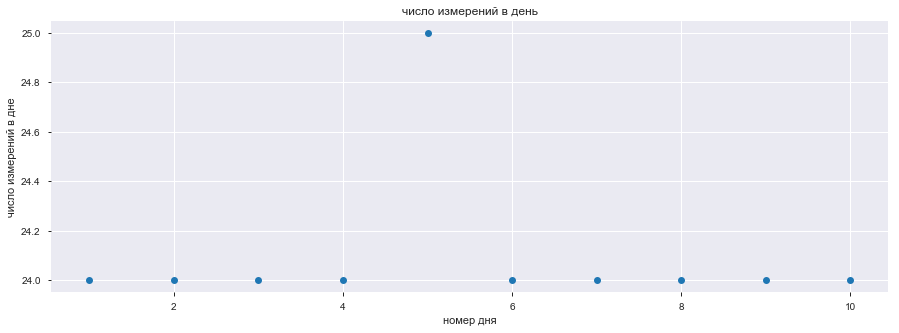

In [13]:
plt.figure(figsize=(15, 5))
plt.plot(day_H.value_counts().index, day_H.value_counts().values ,'o')

plt.xlabel('номер дня')
plt.ylabel('число измерений в дне')
plt.title('число измерений в день')
plt.show()

#### Это может быть связано с переходом на зимнее время. Таким образом, в первое воскресенье ноября продолжительность дня составляет 25 часов, и показания снимаются 25 раз за ден. Наверно будет некорректно удалить одно из показаний под одинаковым индексом, так как сами показания разные, поэтому заменим их на среднее значение.

In [14]:
hourly.loc[hourly['date'] == '2017-11-05 02:00:00', 'DUQ_MW'] = hourly.loc[
    hourly['date'] == '2017-11-05 02:00:00', 'DUQ_MW'].mean()

In [15]:
hourly.loc[hourly['date'] == '2014-11-02 02:00:00', 'DUQ_MW'] = hourly.loc[
    hourly['date'] == '2014-11-02 02:00:00', 'DUQ_MW'].mean()

In [16]:
hourly.loc[hourly['date'] == '2015-11-01 02:00:00', 'DUQ_MW'] = hourly.loc[
    hourly['date'] == '2015-11-01 02:00:00', 'DUQ_MW'].mean()

In [17]:
hourly.loc[hourly['date'] == '2016-11-06 02:00:00', 'DUQ_MW'] = hourly.loc[
    hourly['date'] == '2016-11-06 02:00:00', 'DUQ_MW'].mean()

In [18]:
hourly.loc[hourly['date'] == '2007-07-15 10:00:00', 'DUQ_MW'] = hourly.loc[
    hourly['date'] == '2007-07-15 10:00:00', 'DUQ_MW'].mean()

In [19]:
hourly.drop_duplicates(inplace=True)

In [20]:
hourly.shape

(119064, 2)

Удалим задвоения

In [21]:
hourly.drop_duplicates(inplace=True)
hourly.shape

(119064, 2)

#### Найдем дни, когда был переход на летнее время, в эти дни показания потребления электроэнергии будут зафиксированы 23 раза за день.

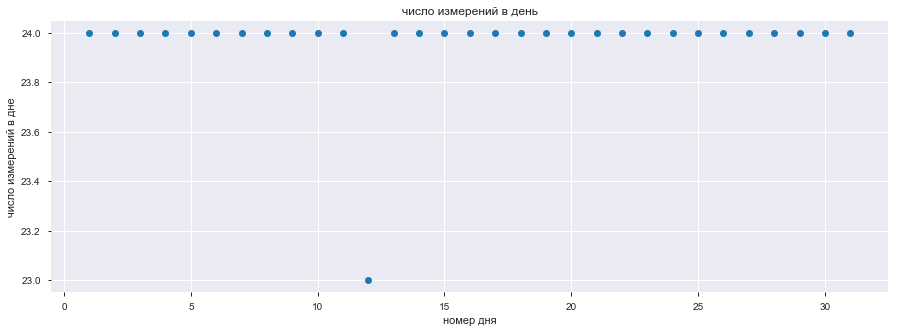

In [22]:
day_H=hourly['2017-03-01 00:00:00':'2017-03-31 23:00:00'].index.day

plt.figure(figsize=(15, 5))
plt.plot(day_H.value_counts().index, day_H.value_counts().values ,'o')

plt.xlabel('номер дня')
plt.ylabel('число измерений в дне')
plt.title('число измерений в день')
plt.show()

In [23]:
Day_count = day_H.value_counts() 
Day_count[Day_count != 24]

12    23
Name: Datetime, dtype: int64

#### При детальном рассмотрении видим, что 12 марта 2017 года пропущены показания от 3-го часа.

In [24]:
hourly['2017-03-12 01:00:00':'2017-03-12 06:00:00'].index

DatetimeIndex(['2017-03-12 01:00:00', '2017-03-12 02:00:00',
               '2017-03-12 04:00:00', '2017-03-12 05:00:00',
               '2017-03-12 06:00:00'],
              dtype='datetime64[ns]', name='Datetime', freq=None)

#### Найдем дни с 23-ми записями

In [25]:
day_H=hourly['2018-03-01 00:00:00':'2018-03-31 23:00:00'].index.day

Day_count = day_H.value_counts() 
d2018 = Day_count[Day_count != 24].index
d2018

Int64Index([11], dtype='int64')

In [26]:
day_H=hourly['2016-03-01 00:00:00':'2016-03-31 23:00:00'].index.day

Day_count = day_H.value_counts() 
d2016 = Day_count[Day_count != 24].index
d2016

Int64Index([13], dtype='int64')

In [27]:
day_H=hourly['2015-03-01 00:00:00':'2015-03-31 23:00:00'].index.day

Day_count = day_H.value_counts() 
d2015 = Day_count[Day_count != 24].index
d2015

Int64Index([8], dtype='int64')

In [28]:
day_H=hourly['2014-03-01 00:00:00':'2014-03-31 23:00:00'].index.day

Day_count = day_H.value_counts() 
d2014 = Day_count[Day_count != 24].index
d2014

Int64Index([9], dtype='int64')

In [29]:
day_H=hourly['2007-03-01 00:00:00':'2007-03-31 23:00:00'].index.day

Day_count = day_H.value_counts() 
d2007 = Day_count[Day_count < 24].index
d2007

Int64Index([11], dtype='int64')

In [30]:
day_H=hourly['2008-03-01 00:00:00':'2008-03-31 23:00:00'].index.day

Day_count = day_H.value_counts() 
d2008 = Day_count[Day_count < 24].index
d2008

Int64Index([9], dtype='int64')

#### Мы можем добавить пропущенные данные интерполяцией

## Прочитайте базу Brent и сделайте ее перерасчет (ресемплинг) в представление по неделям , по месяцам.

In [31]:
brent = pd.read_excel('нефть-brent 2010-2019.xlsx', index_col=[0], parse_dates=[0])

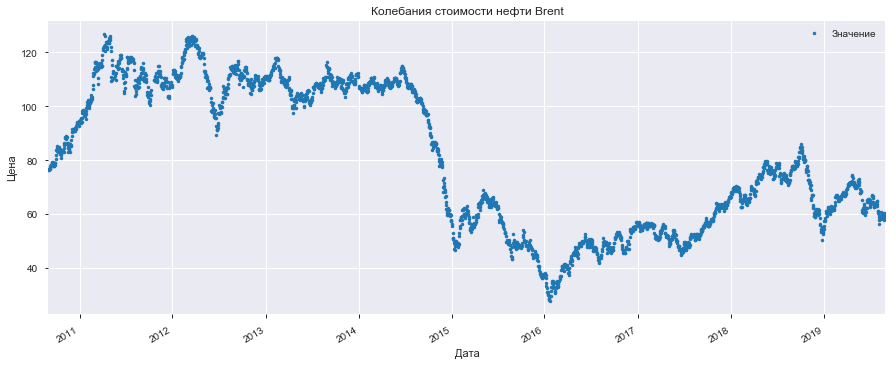

In [32]:
brent.plot(style='.', figsize=(15, 6), title='Колебания стоимости нефти Brent')
plt.ylabel('Цена');

#### Добавим признаков на основе даты и времени

In [33]:
brent['date'] = brent.index

In [34]:
brent['year'] = brent['date'].dt.year
brent['month'] = brent['date'].dt.month
brent['dayofmonth'] = brent['date'].dt.day
brent['quarter'] = brent['date'].dt.quarter
brent['dayofyear'] = brent['date'].dt.dayofyear
brent['weekofyear'] = brent['date'].dt.weekofyear
brent['dayofweek'] = brent['date'].dt.dayofweek
brent['hour'] = brent['date'].dt.hour

In [35]:
brent.head()

,Значение,date,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour
Дата,,,,,,,,,,
2019-09-01,58.84,2019-09-01,2019,9,1,3,244,35,6,0
2019-08-30,59.19,2019-08-30,2019,8,30,3,242,35,4,0
2019-08-29,60.37,2019-08-29,2019,8,29,3,241,35,3,0
2019-08-28,59.84,2019-08-28,2019,8,28,3,240,35,2,0
2019-08-27,59.59,2019-08-27,2019,8,27,3,239,35,1,0


In [36]:
brent.drop(columns='date', inplace=True)
brent.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour
Дата,,,,,,,,,
2019-09-01,58.84,2019,9,1,3,244,35,6,0
2019-08-30,59.19,2019,8,30,3,242,35,4,0
2019-08-29,60.37,2019,8,29,3,241,35,3,0
2019-08-28,59.84,2019,8,28,3,240,35,2,0
2019-08-27,59.59,2019,8,27,3,239,35,1,0


#### Средние значения стоимости нефти по неделям

In [37]:
brent.resample("W").mean().head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour
Дата,,,,,,,,,
2010-09-05,76.616000,2010.0,9.000000,3.000000,3.000000,246.000000,35.0,4.000000,0.0
2010-09-12,77.673333,2010.0,9.000000,8.500000,3.000000,251.500000,36.0,2.500000,0.0
2010-09-19,78.693333,2010.0,9.000000,15.666667,3.000000,258.666667,37.0,2.666667,0.0
2010-09-26,78.518333,2010.0,9.000000,22.666667,3.000000,265.666667,38.0,2.666667,0.0
2010-10-03,81.211667,2010.0,9.333333,19.666667,3.333333,272.666667,39.0,2.666667,0.0


#### Средние значения стоимости нефти по месяцам

In [38]:
brent.resample("M").mean().head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour
Дата,,,,,,,,,
2010-09-30,78.228148,2010.0,9.0,15.185185,3.0,258.185185,36.925926,2.703704,0.0
2010-10-31,83.473462,2010.0,10.0,16.000000,4.0,289.000000,41.307692,2.846154,0.0
2010-11-30,86.178077,2010.0,11.0,15.346154,4.0,319.346154,45.692308,2.500000,0.0
2010-12-31,92.232308,2010.0,12.0,16.384615,4.0,350.384615,50.115385,2.576923,0.0
2011-01-31,97.033200,2011.0,1.0,16.680000,1.0,16.680000,4.640000,2.760000,0.0


## Постройте график изменения среднего по выборке и среднего отклонения по выборке на недельных, месячных и годовых группах для Brent.

#### Средняя цена по неделям

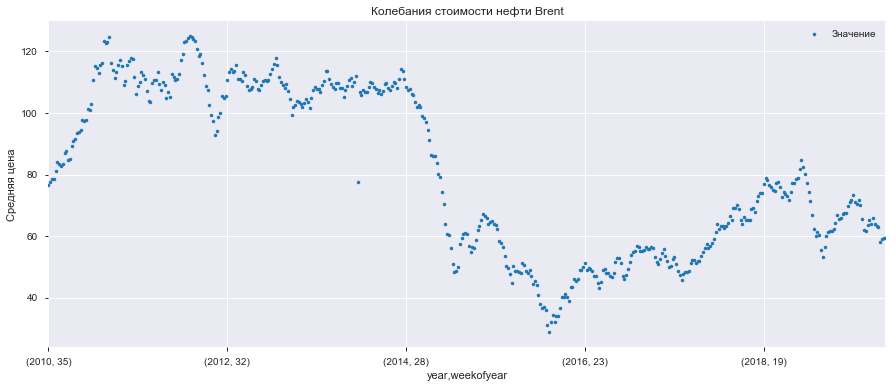

In [39]:
brent.groupby(['year', 'weekofyear']).agg({"Значение": "mean"}).plot(
    style='.', figsize=(15, 6), title='Колебания стоимости нефти Brent')
plt.ylabel('Средняя цена');

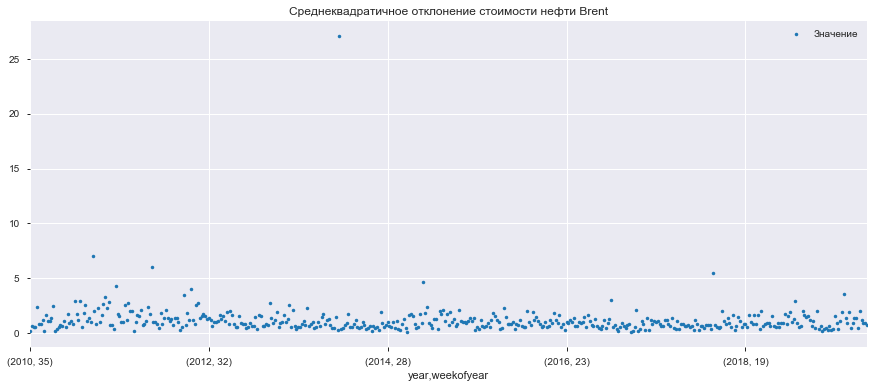

In [41]:
brent.groupby(['year', 'weekofyear']).agg({"Значение": "std"}).plot(
    style='.', figsize=(15, 6), title='Среднеквадратичное отклонение стоимости нефти Brent');

#### Средняя цена по месяцам

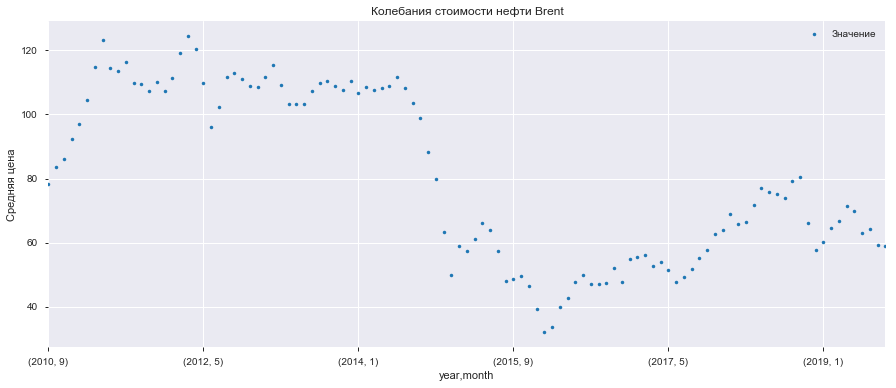

In [42]:
brent.groupby(['year', 'month']).agg({"Значение": "mean"}).plot(
    style='.', figsize=(15, 6), title='Колебания стоимости нефти Brent')
plt.ylabel('Средняя цена');

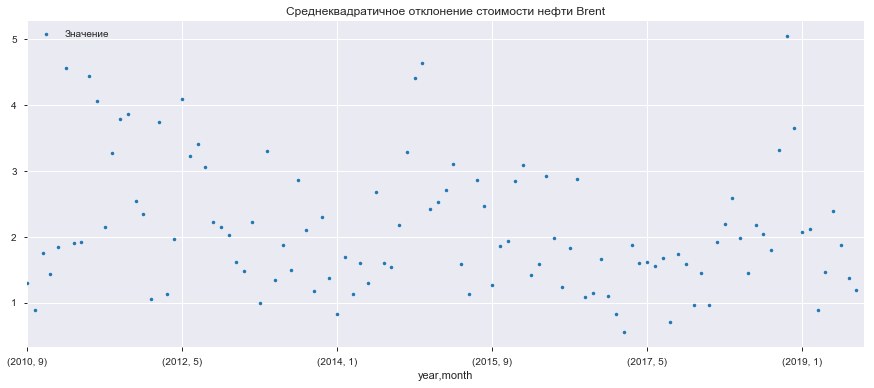

In [43]:
brent.groupby(['year', 'month']).agg({"Значение": "std"}).plot(
    style='.', figsize=(15, 6), title='Среднеквадратичное отклонение стоимости нефти Brent');

#### Среднегодичные цены

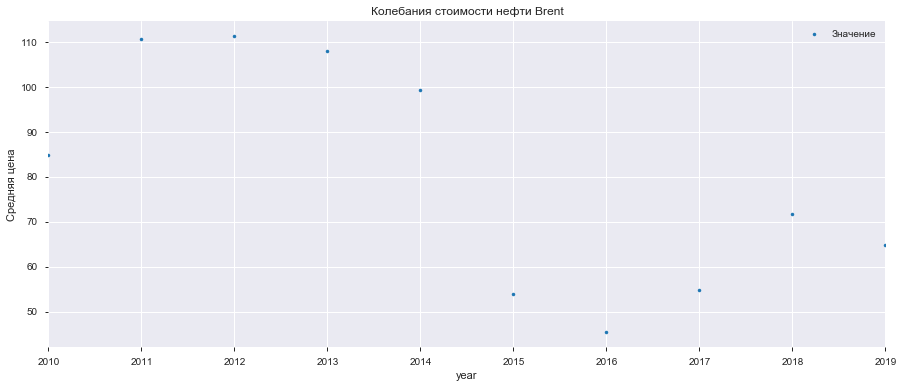

In [44]:
brent.groupby(['year']).agg({"Значение": "mean"}).plot(
    style='.', figsize=(15, 6), title='Колебания стоимости нефти Brent')
plt.ylabel('Средняя цена');

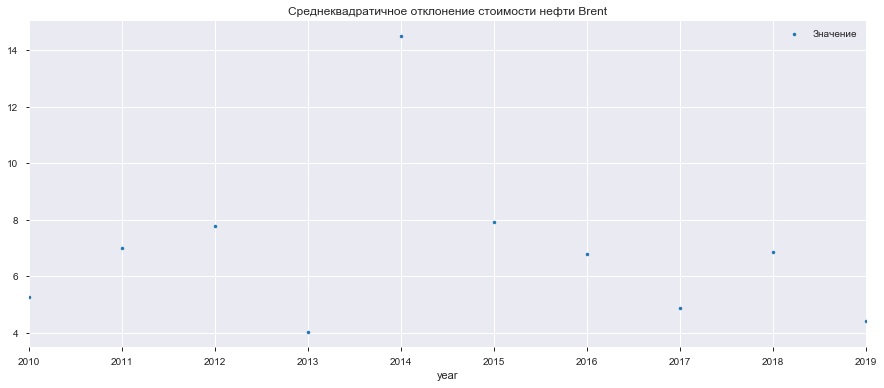

In [45]:
brent.groupby(['year']).agg({"Значение": "std"}).plot(
    style='.', figsize=(15, 6), title='Среднеквадратичное отклонение стоимости нефти Brent');

## Сделайте вывод о том, как изменилось поведение цены на недельных и месячных графиках по сравнению с дневными.

Месячные колебания цены больше недельных, которые, в свою очередь, больше дневных.